In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers, metrics
import keras.backend as K
from keras.initializers import glorot_uniform
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.utils import np_utils, plot_model
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [2]:
raw_data = pd.read_csv('data/fer2013.csv')

X = []
y = []

for index, data in tqdm(raw_data.iterrows()):
    #merges "Anger" and "Disgust" into one emotion as "Disgust" has very few examples and both are similar emotions.
    if(data['emotion']==0):
        y.append(0)
    else:
        y.append(data['emotion']-1)
    x = data['pixels'].split(" ")
    _x = [int(d) for d in x]
    X.append(_x)

X = np.asarray(X)
y = np.asarray(y)
X = np.reshape(X, (35887, 48, 48, 1 ))
y = np.reshape(y, (35887, 1 ))
y = np_utils.to_categorical(y, 6)

print X.shape
print y.shape

35887it [00:43, 816.04it/s]


(35887, 48, 48, 1)
(35887, 6)


In [3]:
X = X/225.

train_X = []
train_y = []
test_X = []
test_y = []

train_X = X[:30000,:,:,:]
train_y = y[:30000,:]

test_X = X[30000:,:,:,:]
test_y = y[30000:, :]

print train_X.shape
print train_y.shape
print test_X.shape
print test_y.shape

(30000, 48, 48, 1)
(30000, 6)
(5887, 48, 48, 1)
(5887, 6)


[ 0.  0.  0.  0.  0.  1.]


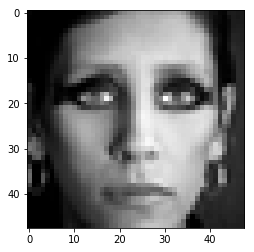

In [4]:
print train_y[4]
img_array = train_X[4]
img_array = np.reshape(img_array, (48, 48))

plt.imshow(img_array, cmap="gray")

In [5]:
def inception_block(input_x, filters):
    f1, f2, f3, f4, f5, f6 = filters
    
    X = input_x
    
    conv1_1x1 = layers.Conv2D(f1, kernel_size=(1,1), padding='same', kernel_initializer=glorot_uniform())(input_x)
    conv1_1x1 = layers.Activation('relu')(conv1_1x1)
    
    conv2_1x1 = layers.Conv2D(f2, kernel_size=(1,1), padding='same', kernel_initializer=glorot_uniform())(input_x)
    conv2_1x1 = layers.Activation('relu')(conv2_1x1)
    conv2_3x3 = layers.Conv2D(f3, kernel_size=(3,3), padding='same', kernel_initializer=glorot_uniform())(conv2_1x1)
    conv2_3x3 = layers.Activation('relu')(conv2_3x3)
    
    conv3_1x1 = layers.Conv2D(f4, kernel_size=(1,1), padding='same', kernel_initializer=glorot_uniform())(input_x)
    conv3_1x1 = layers.Activation('relu')(conv3_1x1)
    conv3_5x5 = layers.Conv2D(f5, kernel_size=(5,5), padding='same', kernel_initializer=glorot_uniform())(conv3_1x1)
    conv3_5x5 = layers.Activation('relu')(conv3_5x5)
    
    pool = layers.MaxPool2D(pool_size=(3,3), strides=(1,1), padding="same")(input_x)
    conv_pool_1x1 = layers.Conv2D(f6, kernel_size=(1,1), padding='same', kernel_initializer=glorot_uniform())(pool)
    conv_pool_1x1 = layers.Activation('relu')(conv_pool_1x1)
    
    output = layers.Concatenate(axis=-1)([conv1_1x1, conv2_3x3, conv3_5x5, conv_pool_1x1])
    
    return output

In [6]:
def model_def(input_shape, n_classes):
    input_x = layers.Input(input_shape)
    
    X = input_x
    
    X = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer=glorot_uniform())(X)
    X = layers.Activation('relu')(X)
    
    X = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid")(X)
    
    X = layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), padding="same", kernel_initializer=glorot_uniform())(X)
    X = layers.Activation('relu')(X)
    
    X = inception_block(X, [64, 96, 128, 16, 32, 32])
    
    X = inception_block(X, [128, 128, 192, 32, 96, 64])
    
    X = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid")(X)
    
    X = inception_block(X, [192, 96, 208, 16, 48, 64])
    
    X = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid")(X)
    
    X = inception_block(X, [256, 160, 320, 32, 128, 128])
    
    X = inception_block(X, [384, 192, 384, 48, 128, 128])
    
    X = layers.MaxPool2D(pool_size=(3,3), strides=(1,1), padding="valid")(X)
    
    X = layers.Flatten()(X)
    
    X = layers.Dropout(0.4)(X)
    
    X = layers.Dense(n_classes, activation='softmax')(X)
    
    model = keras.Model(inputs=input_x, outputs=X)
    
    model.load_weights('models/er_model_1.h5')
    
    return model
    

In [7]:
er_model = model_def(input_shape = (48, 48, 1), n_classes=6)

In [19]:
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top2_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=2)

top3_acc.__name__ = 'top3_acc'
top2_acc.__name__ = 'top2_acc'

In [20]:
er_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', top2_acc, top3_acc])

In [21]:
datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(train_X)

In [24]:
history = er_model.fit_generator(datagen.flow(train_X, train_y, batch_size=32), 
             steps_per_epoch=len(train_X) / 32, epochs = 2, shuffle=True)

Epoch 1/2
937/937 [==============================] - 388s 414ms/step - loss: 1.2701 - acc: 0.5021 - top2_acc: 0.7052 - top3_acc: 0.8357
Epoch 2/2
937/937 [==============================] - 388s 414ms/step - loss: 1.2500 - acc: 0.5115 - top2_acc: 0.7143 - top3_acc: 0.8418


In [25]:
loss, acc, acc2, acc3 = er_model.evaluate(test_X, test_y)
print acc, acc2, acc3

5887/5887 [==============================] - 23s 4ms/step
0.536775946921 0.740105316698 0.86699507376


In [47]:
er_model.save_weights("models/er_model_1.h5")

In [48]:
plot_model(er_model, "model.png", show_shapes=True)